# </Center> 5: Classification </center>

## 1: Classification

- Define a function `create_model(train_docs, train_y, test_docs, test_y, model_type='svm', stop_words='english', min_df = 1, print_result = True, algorithm_para=1.0`), where

    - `train_docs`: is a list of documents for training
    - `train_y`: is the ground-truth labels of training documents
    - `test_docs`: is a list of documents for test
    - `test_y`: is the ground-truth labels of test documents
    - `model_type`: two options: `nb` (Multinomial Naive Bayes) or `svm` (Linear SVM)
    - `stop_words`: indicate whether stop words should be removed. The default value is 'english', i.e. remove English stopwords.
    - `min_df`: only word with document frequency above this threshold can be included. The default is 1. 
    - `print_result`: controls whether to show classification report or plots. The default is True.
    - `algorithm_para`: the hyperparameter of algorithms, here refers to C in SVM and alpha in NB. Both C and alpha have default values of 1.0. 
    Sklearn documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html


- This function does the following:
    - Fit a `TfidfVectorizer` using `train_docs` with options `stop_words, min_df` as specified in the function inputs. Extract features from `train_docs` using the fitted `TfidfVectorizer`.
    - Build `linear SVM` or `Multinomial Naive Bayes` model as specified by `model_type` with `algorithm_para` setting. Train the model using the extracted features and `train_y`. 
    - Transform `test_docs` by the fitted `TfidfVectorizer`.
    - Predict the labels for `test_docs`. If `print_result` is True, print the classification report.
    - Calculate the AUC score and PRC score (or Average Precision) for class 1 on the test dataset. If `print_result` is True, plot the ROC and PRC curves. 
    
    Note: 
        - `sklearn.svm.LinearSVM` does not provide `predict_proba` function. 
        - Instead, I will use its `decision_function` (see <a href = "https://stackoverflow.com/questions/59227176/how-to-plot-roc-and-calculate-auc-for-binary-classifier-with-no-probabilities-s">some referenc code</a>) 
        - Another option is to use `sklearn.svm.SVC` with `kernel='linear' and probability=False` (see <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html"> reference</a>)
    - Return the AUC and PRC scores.

    
- Test my function with following cases:
    - model_type='svm', stop_words = 'english', min_df = 1
    - model_type='nb', stop_words = 'english', min_df = 1

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

train = pd.read_csv("train5.csv")
test = pd.read_csv("test5.csv")
train_docs, train_y, test_docs, test_y = train.iloc[:,2], train.iloc[:,1].astype(int), test.iloc[:,2], test.iloc[:,1].astype(int)

In [5]:
# Define the function for Task 1

def create_model(train_docs, train_y, test_docs, test_y,model_type='svm', stop_words='english', min_df=1, print_result=True, algorithm_para=1.0):
    tfidf_vect = TfidfVectorizer(stop_words=stop_words, min_df=min_df)
    train_result = tfidf_vect.fit_transform(train_docs)
    # SVM
    if model_type == 'svm':
        C = algorithm_para
        clf = svm.LinearSVC(C=C)
        clf.fit(train_result, train_y)
        test_result = tfidf_vect.transform(test_docs)
        # predict
        decision_scores = clf.decision_function(test_result)
        # AUC
        fpr, tpr, thres = roc_curve(test_y, decision_scores)
        # PRC
        precision, recall, thresholds = precision_recall_curve(test_y, decision_scores)
        print('AUC: {:.2%}'.format(auc(fpr, tpr)), 'Average Precision: {:.2%}'.format(auc(recall, precision)))

        # plot
        from matplotlib import pyplot as plt
        plt.figure();
        plt.plot(fpr, tpr, color='darkorange', lw=2);
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
        plt.xlim([0.0, 1.0]);
        plt.ylim([0.0, 1.05]);
        plt.xlabel('False Positive Rate');
        plt.ylabel('True Positive Rate');
        plt.title('AUC of SVM');
        plt.show();

        plt.figure();
        plt.plot(recall, precision, color='darkorange', lw=2);
        plt.xlim([0.0, 1.0]);
        plt.ylim([0.0, 1.05]);
        plt.xlabel('Recall');
        plt.ylabel('Precision');
        plt.title('Precision_Recall_Curve of SVM');
        plt.show();

        if print_result == True:
            y_pred = clf.predict(test_result)
            matrix = classification_report(test_y, y_pred)
        else:
            matrix = None
        print(matrix)


    if model_type != 'svm':
        # native Bayes
        # train a multinomial naive Bayes model using the testing data
        clf = MultinomialNB(alpha=algorithm_para).fit(train_result, train_y)
        nb_trans = tfidf_vect.transform(test_docs)
        # predict the news group for the test dataset
        predicted = clf.predict_proba(nb_trans)
        fpr, tpr, thresholds = roc_curve(test_y, predicted[:, 1])
        precision, recall, thresholds = precision_recall_curve(test_y, predicted[:, 1])
        # calculate auc
        print("AUC: {:.2%}".format(auc(fpr, tpr)), "Average Precision: {:.2%}".format(auc(recall, precision)))
        # plot auc
        from matplotlib import pyplot as plt
        plt.figure();
        plt.plot(fpr, tpr, color='darkorange', lw=2);
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
        plt.xlim([0.0, 1.0]);
        plt.ylim([0.0, 1.05]);
        plt.xlabel('False Positive Rate');
        plt.ylabel('True Positive Rate');
        plt.title('AUC of Naive Bayes Model');
        plt.show();

        # plot precision_recall_curve
        # compute precision/recall by different thresholds
        plt.figure();
        plt.plot(recall, precision, color='darkorange', lw=2);
        plt.xlim([0.0, 1.0]);
        plt.ylim([0.0, 1.05]);
        plt.xlabel('Recall');
        plt.ylabel('Precision');
        plt.title('Precision_Recall_Curve of Naive Bayes Model');
        plt.show();
        if print_result == True:
            y_pred = clf.predict(nb_trans)
            matrix = classification_report(test_y, y_pred)
        else:
            matrix = None
            
        print(matrix)

        # add your code here
    auc_score, prc_score = None, None
    return auc_score, prc_score


    

AUC: 91.50% Average Precision: 91.59%


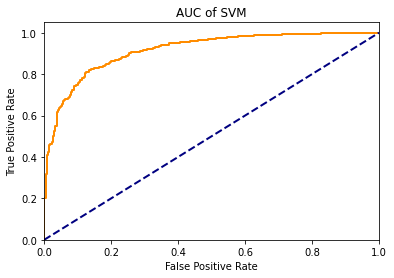

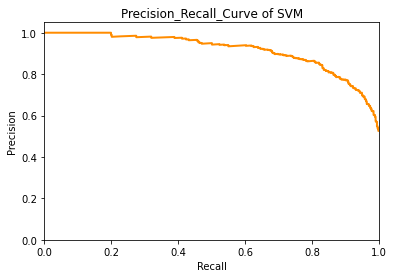

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       509
           1       0.82      0.84      0.83       491

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



In [6]:
# Test the function with 'svm'

auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], \
          model_type='svm', stop_words = 'english', min_df = 1, print_result=True, algorithm_para=1.0)

AUC: 88.87% Average Precision: 89.49%


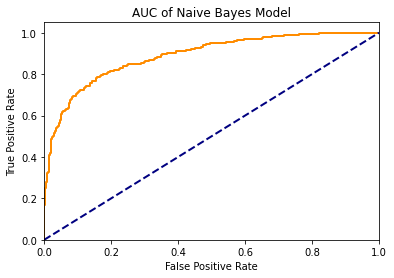

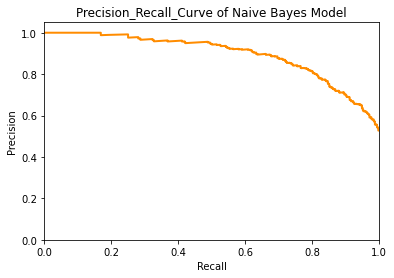

              precision    recall  f1-score   support

           0       0.82      0.77      0.80       509
           1       0.78      0.83      0.80       491

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



In [7]:
# Test the function with 'nb' 

auc_score, prc_score = create_model(train["text"], train["label"], test["text"], test["label"], \
                    model_type='nb', stop_words = 'english', min_df = 1, print_result=True, algorithm_para=1.0)

### 2: Search for best parameters 

From Task 1, there are many possible ways to configure parameters. Next, let's use grid search to find the optimal parameters

- Define a function `search_para(docs, y)` where `docs` are training documents and `y` is the ground-truth labels.
- This function does the following:
    - Create a pipleline which integrates `TfidfVectorizer` and `SVM` classifier 
    - Define the parameter ranges as follow:
        - `stop_words': [None, 'english']`
        - `min_df: [1,2,5]`
        - `C: [0.2,0.5,0.8]`
    - Set the scoring metric to "f1_macro"
    - Use `GridSearchCV` with `5-fold cross validation` to find the best parameter values based on the training dataset. 
    - Print the best parameter values
    
- Call the function `svm_model` defined in last task 1 `with the best parameter values`. I will add the best C value to the original function, because used default settings of the SVM classifier previously.

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import model_selection

In [4]:
def search_para(docs, y):
    
    # Add your code here
    text_clf = Pipeline([('TfidfVectorizer', TfidfVectorizer()),('SVM', svm.LinearSVC())])
    parameters = {'TfidfVectorizer__min_df':[1,2,5],
                  'TfidfVectorizer__stop_words':[None,"english"],
                  'SVM__C': [0.2,0.5,0.8],
    }
    metric =  "f1_macro"
    gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)

    gs_clf = gs_clf.fit(train_docs,train_y)
     
    return gs_clf.best_params_


In [5]:
search_para(train["text"], train["label"])

{'SVM__C': 0.2,
 'TfidfVectorizer__min_df': 2,
 'TfidfVectorizer__stop_words': None}

AUC: 92.42% Average Precision: 92.30%


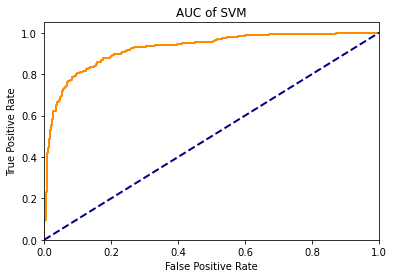

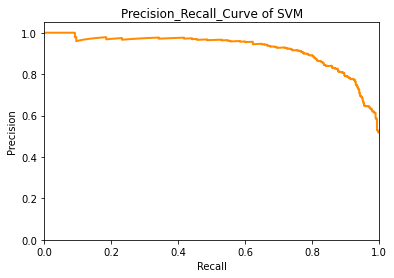

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       509
           1       0.85      0.84      0.84       491

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



In [15]:
# call the function with the best parameters

auc_score, prc_score = create_model(train["text"], train["label"], test["text"], test["label"], \
          model_type='svm', stop_words = None, min_df = 2, print_result=True, algorithm_para=0.2)




## 3. How many samples are enough? 

Impact of sample size on classifier performance. 

- Define a function `sample_size_impact(train_docs, train_y, test_docs, test_y)` with the input as defined above. 
    
    
- This function does the following:
    - Starting with 500 samples, in each round I build a classifier with 500 more samples. i.e. in round 1, using samples from 0:500, and in round 2, using samples from 0:1000, …, until use all samples. 
    - In each round, call the `create_model` function with `model_type='svm'` and then `model_type='nb'`. Keep other parameters as default. Record the AUC score of each model type and the sample size.
    - For each model type, I will plot a line chart show the relationship between sample size and the AUC score. 
    - This function has no return.
    

In [13]:
import numpy as np
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score

In [16]:
# Show the impact of sample size
def sample_size_impact(train_docs, train_y, test_docs, test_y):  
    
    # add your code here
    svm_1 = []
    nb = []
    for i in range(500, len(train_docs), 500):
        tfidf_model_train = TfidfVectorizer(stop_words=None, min_df=1).fit(train_docs[:i])
        train_result = tfidf_model_train.transform(train_docs[:i])
        test_result = tfidf_model_train.transform(test_docs)

        clf1 = svm.LinearSVC(C=0.2)
        clf1.fit(train_result, train_y[:i])

        decision_scores = clf1.decision_function(test_result)
        AUC_svm = roc_auc_score(test_y, decision_scores)
        svm_1.append(AUC_svm)

        clf2 = MultinomialNB(alpha=1)
        clf2.fit(train_result, train_y[:i])

        y_pred_clf = clf2.predict_proba(test_result)
        _proba = y_pred_clf[:, 1]
        AUC_nb = roc_auc_score(test_y, _proba)
        nb.append(AUC_nb)
        if len(svm_1) == 23:
            from matplotlib import pyplot as plt
            plt.figure();
            plt.plot(range(500, len(train_docs), 500), svm_1, color='orange', label='SVM')
            plt.plot(range(500, len(train_docs), 500), nb, color='blue', label='NB')
            plt.legend(fontsize=20)
            plt.legend(loc="upper left")
            plt.xlabel('sample size')
            plt.ylabel('AUC')
            plt.show();

        
        
        

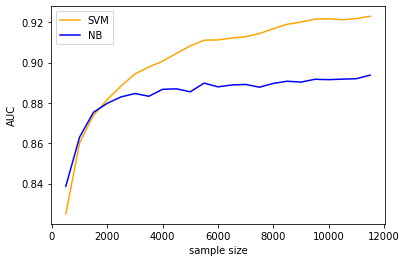

In [17]:
# Test the function

sample_size_impact(train["text"], train["label"], test["text"], test["label"])


(1)The larger the sample size, the greater the AUC score
(2)We can see in the figure that when the sample size exceeds 4000, the increase in AUC is not particularly large.
(3)SVM is better than NB model